In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data downloading

In [14]:
import csv
import requests
from io import StringIO

# URL of the input file
input_url = "https://raw.githubusercontent.com/Benz-Poobua/ESS_523/main/HW1_GNSS_data.txt"

# Output file (CSV)
output_file = "GNSS_data.csv"

# Fetching data from URL
response = requests.get(input_url)

# Checking if request was successful
if response.status_code == 200:
    # Read the data from the response
    data = response.text

    # Read the data and write it to CSV
    with open(output_file, 'w', newline='') as outfile:
        # Create a CSV writer object
        writer = csv.writer(outfile)
        
        # Write the header row
        writer.writerow(["x_position(km)", "Surface_velocity(mm/yr)", "uncertainty(mm/yr)"])
        
        # Skip the header lines
        data_lines = data.strip().split('\n')[3:]
        
        # Write the data rows
        for line in data_lines:
            # Split the line based on whitespace
            columns = line.split()
            # Write the columns to CSV
            writer.writerow(columns)

    print("Data converted to CSV successfully. Converted data saved to", output_file)
else:
    print("Failed to retrieve data from the URL.")


Data converted to CSV successfully. Converted data saved to converted_data.csv


In [2]:
GNSS_data = pd.read_csv('https://raw.githubusercontent.com/Benz-Poobua/ESS_523/main/GNSS_data.csv')

In [7]:
GNSS_data

,x_position(km),Surface_velocity(mm/yr),uncertainty(mm/yr)
0,5.0,-26.8789,1.5905
1,20.0,-27.1257,0.8008
2,25.0,-27.4999,1.1438
3,70.0,-14.9070,2.6112
4,105.0,-5.9737,0.8839
5,185.0,18.3194,0.7195
6,200.0,19.0408,2.0715
7,208.0,21.6918,1.3580
8,220.0,25.0392,1.0329
9,290.0,28.7211,0.8648


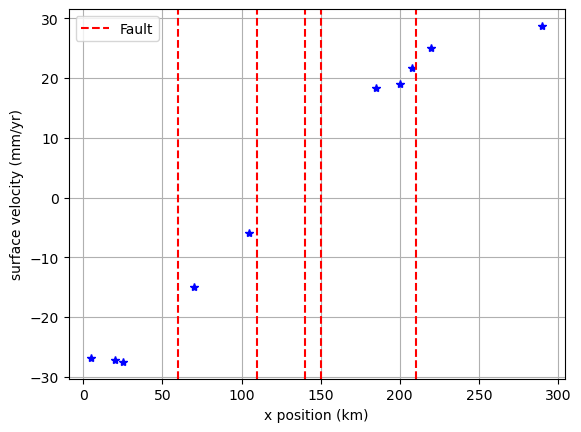

In [16]:
plt.plot(GNSS_data['x_position(km)'], GNSS_data['Surface_velocity(mm/yr)'], '*b')
plt.xlabel('x position (km)')
plt.ylabel('surface velocity (mm/yr)')
plt.grid()

# Draw vertical red lines at specific x-axis positions
x_positions = [60, 110, 140, 150, 210]
for x in x_positions:
    plt.axvline(x, color='red', linestyle='dashed')

# Create a dummy plot for legend
plt.plot([], [], color='red', linestyle='dashed', label='Fault')

# Display legend
plt.legend()

plt.show()

## Model equation

In [27]:
# data

d = GNSS_data['Surface_velocity(mm/yr)']

# Convert to NumPy array and reshape
d_matrix = d.values.reshape(-1, 1)

print(d_matrix)


[[-26.8789]
 [-27.1257]
 [-27.4999]
 [-14.907 ]
 [ -5.9737]
 [ 18.3194]
 [ 19.0408]
 [ 21.6918]
 [ 25.0392]
 [ 28.7211]]


In [36]:
x_gnss = GNSS_data['x_position(km)']
x_fault = [60, 110, 140, 150, 210]
locking_depth = [10, 10, 5, 15, 12]

# Initialize a 10x5 matrix filled with zeros
G = np.zeros((10, 5))

# Iterate over each element in the matrix
for i in range(10):
    for j in range(5):
        G[i, j] = np.arctan((x_gnss[i] - x_fault[j]) / locking_depth[j])

print(G)


[[-1.39094283 -1.47584462 -1.53377621 -1.46771472 -1.51232646]
 [-1.32581766 -1.46013911 -1.52915375 -1.45591972 -1.50772221]
 [-1.29249667 -1.45368758 -1.52734543 -1.4513674  -1.5060222 ]
 [ 0.78539816 -1.32581766 -1.49948886 -1.38544838 -1.48529103]
 [ 1.35212738 -0.46364761 -1.42889927 -1.24904577 -1.45700432]
 [ 1.49096634  1.43824479  1.46013911  1.16590454 -1.12327635]
 [ 1.49948886  1.46013911  1.48765509  1.27933953 -0.69473828]
 [ 1.5033313   1.46910748  1.497399    1.31772067 -0.16514868]
 [ 1.50837752  1.48013644  1.50837752  1.35970299  0.69473828]
 [ 1.52734543  1.51529782  1.53747533  1.46406065  1.42190638]]
